In [5]:
import requests
from pathlib import Path
from datetime import datetime
import time
import csv
import re, json
from collections import defaultdict
import matplotlib.pyplot as plt

In [7]:
from typing import Optional, Tuple
CTRL = Path("control")
CTRL.mkdir(exist_ok=True)


LOG_CSV   = CTRL / "control_log.csv"
DOWN_TXT  = CTRL / "downloaded_books.txt"


START_MARKER = "*** START OF THE PROJECT GUTENBERG EBOOK"
END_MARKER   = "*** END OF THE PROJECT GUTENBERG EBOOK"


def already_downloaded(book_id: int) -> bool:
    return DOWN_TXT.exists() and str(book_id) in DOWN_TXT.read_text(encoding="utf-8").splitlines()


def download_book(book_id: int, base: str = "datalake") -> Optional[Tuple[Path, Path]]:
    if already_downloaded(book_id):
        print(f"[SKIP] {book_id} was already downloaded")
        return None
   
    now = datetime.now()
    base_dir = Path(base) / now.strftime("%Y%m%d") / now.strftime("%H")
    base_dir.mkdir(parents=True, exist_ok=True)


    url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    text = resp.text
    
    if START_MARKER not in text or END_MARKER not in text:
        print(f"[ERROR] Marcadores no encontrados en el libro {book_id}")
        return None


    header, body_and_footer = text.split(START_MARKER, 1)
    body, _footer = body_and_footer.split(END_MARKER, 1)


    header_path = base_dir / f"{book_id}.header.txt"
    body_path   = base_dir / f"{book_id}.body.txt"


    header_path.write_text(header.strip(), encoding="utf-8")
    body_path.write_text(body.strip(), encoding="utf-8")


    print(f"[OK] {book_id} -> {header_path} / {body_path}")
    return header_path, body_path

In [8]:
def register_in_control(book_id: int, header_path: Path, body_path: Path, state="OK"):
    if not LOG_CSV.exists():
        with open(LOG_CSV, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow(["book_id", "date", "header_file", "body_file", "state"])
    with open(LOG_CSV, "a", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow([
            book_id,
            datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            str(header_path),
            str(body_path),
            state
        ])


    with open(DOWN_TXT, "a", encoding="utf-8") as f:
        f.write(f"{book_id}\n")


    print(f"[CONTROL] Registrado {book_id} en control_log.csv y downloaded_books.txt")

In [10]:
import time
import random
from tqdm import tqdm


def download_multiple(ids: list[int], max_books: int = 300, base: str = "datalake"):
    valid_count = 0
    with tqdm(total=max_books, desc="Descargando libros válidos", unit="libro") as pbar:
        for bid in ids:
            if valid_count >= max_books:
                print(f"[INFO] Se alcanzó el límite de {max_books} libros válidos.")
                break


            if already_downloaded(bid):
                # Ya descargado, no cuenta como válido nuevo
                continue


            try:
                res = download_book(bid, base=base)
                if res:
                    header_path, body_path = res
                    register_in_control(bid, header_path, body_path)
                    valid_count += 1
                    pbar.update(1)  # Avanza la barra en uno
                else:
                    register_in_control(bid, "-", "-", state="FAILED")
            except Exception as e:
                print(f"[ERROR] Falló la descarga del libro {bid}: {e}")
                register_in_control(bid, "-", "-", state="FAILED")


            # Pausa aleatoria entre 1 y 3 segundos para no saturar el servidor
            time.sleep(random.uniform(1, 3))


    print(f"[INFO] Descargados {valid_count} libros válidos hasta ahora.")

In [11]:
book_ids = list(range(1, 30000))  # Rango de IDs a probar
download_multiple(book_ids, max_books=300)

Descargando libros válidos:   0%|          | 1/300 [00:00<04:45,  1.05libro/s]

[OK] 1 -> datalake/20251005/19/1.header.txt / datalake/20251005/19/1.body.txt
[CONTROL] Registrado 1 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   1%|          | 2/300 [00:04<13:36,  2.74s/libro]

[OK] 2 -> datalake/20251005/19/2.header.txt / datalake/20251005/19/2.body.txt
[CONTROL] Registrado 2 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   1%|          | 3/300 [00:08<15:54,  3.21s/libro]

[OK] 3 -> datalake/20251005/19/3.header.txt / datalake/20251005/19/3.body.txt
[CONTROL] Registrado 3 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   1%|▏         | 4/300 [00:12<16:47,  3.40s/libro]

[OK] 4 -> datalake/20251005/19/4.header.txt / datalake/20251005/19/4.body.txt
[CONTROL] Registrado 4 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   2%|▏         | 5/300 [00:15<15:36,  3.17s/libro]

[OK] 5 -> datalake/20251005/19/5.header.txt / datalake/20251005/19/5.body.txt
[CONTROL] Registrado 5 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   2%|▏         | 6/300 [00:18<16:16,  3.32s/libro]

[OK] 6 -> datalake/20251005/19/6.header.txt / datalake/20251005/19/6.body.txt
[CONTROL] Registrado 6 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   2%|▏         | 7/300 [00:22<16:57,  3.47s/libro]

[OK] 7 -> datalake/20251005/19/7.header.txt / datalake/20251005/19/7.body.txt
[CONTROL] Registrado 7 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   3%|▎         | 8/300 [00:26<17:19,  3.56s/libro]

[OK] 8 -> datalake/20251005/19/8.header.txt / datalake/20251005/19/8.body.txt
[CONTROL] Registrado 8 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   3%|▎         | 9/300 [00:29<16:29,  3.40s/libro]

[OK] 9 -> datalake/20251005/19/9.header.txt / datalake/20251005/19/9.body.txt
[CONTROL] Registrado 9 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   3%|▎         | 10/300 [00:34<18:58,  3.93s/libro]

[OK] 10 -> datalake/20251005/19/10.header.txt / datalake/20251005/19/10.body.txt
[CONTROL] Registrado 10 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   4%|▎         | 11/300 [00:36<16:40,  3.46s/libro]

[OK] 11 -> datalake/20251005/19/11.header.txt / datalake/20251005/19/11.body.txt
[CONTROL] Registrado 11 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   4%|▍         | 12/300 [00:39<14:43,  3.07s/libro]

[OK] 12 -> datalake/20251005/19/12.header.txt / datalake/20251005/19/12.body.txt
[CONTROL] Registrado 12 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   4%|▍         | 13/300 [00:42<15:48,  3.30s/libro]

[OK] 13 -> datalake/20251005/19/13.header.txt / datalake/20251005/19/13.body.txt
[CONTROL] Registrado 13 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   5%|▍         | 14/300 [00:45<15:24,  3.23s/libro]

[OK] 14 -> datalake/20251005/19/14.header.txt / datalake/20251005/19/14.body.txt
[CONTROL] Registrado 14 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   5%|▌         | 15/300 [00:49<16:00,  3.37s/libro]

[OK] 15 -> datalake/20251005/19/15.header.txt / datalake/20251005/19/15.body.txt
[CONTROL] Registrado 15 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   5%|▌         | 16/300 [00:53<17:05,  3.61s/libro]

[OK] 16 -> datalake/20251005/19/16.header.txt / datalake/20251005/19/16.body.txt
[CONTROL] Registrado 16 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   6%|▌         | 17/300 [00:57<17:18,  3.67s/libro]

[OK] 17 -> datalake/20251005/19/17.header.txt / datalake/20251005/19/17.body.txt
[CONTROL] Registrado 17 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   6%|▌         | 18/300 [01:01<17:56,  3.82s/libro]

[OK] 18 -> datalake/20251005/19/18.header.txt / datalake/20251005/19/18.body.txt
[CONTROL] Registrado 18 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   6%|▋         | 19/300 [01:04<16:56,  3.62s/libro]

[OK] 19 -> datalake/20251005/19/19.header.txt / datalake/20251005/19/19.body.txt
[CONTROL] Registrado 19 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   7%|▋         | 20/300 [01:09<18:00,  3.86s/libro]

[OK] 20 -> datalake/20251005/19/20.header.txt / datalake/20251005/19/20.body.txt
[CONTROL] Registrado 20 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   7%|▋         | 21/300 [01:13<17:46,  3.82s/libro]

[OK] 21 -> datalake/20251005/19/21.header.txt / datalake/20251005/19/21.body.txt
[CONTROL] Registrado 21 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   7%|▋         | 22/300 [01:16<17:26,  3.76s/libro]

[OK] 22 -> datalake/20251005/19/22.header.txt / datalake/20251005/19/22.body.txt
[CONTROL] Registrado 22 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   8%|▊         | 23/300 [01:20<16:57,  3.67s/libro]

[OK] 23 -> datalake/20251005/19/23.header.txt / datalake/20251005/19/23.body.txt
[CONTROL] Registrado 23 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   8%|▊         | 24/300 [01:23<16:01,  3.48s/libro]

[OK] 24 -> datalake/20251005/19/24.header.txt / datalake/20251005/19/24.body.txt
[CONTROL] Registrado 24 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   8%|▊         | 25/300 [01:27<17:23,  3.79s/libro]

[OK] 25 -> datalake/20251005/19/25.header.txt / datalake/20251005/19/25.body.txt
[CONTROL] Registrado 25 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   9%|▊         | 26/300 [01:31<17:52,  3.92s/libro]

[OK] 26 -> datalake/20251005/19/26.header.txt / datalake/20251005/19/26.body.txt
[CONTROL] Registrado 26 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   9%|▉         | 27/300 [01:34<16:01,  3.52s/libro]

[OK] 27 -> datalake/20251005/19/27.header.txt / datalake/20251005/19/27.body.txt
[CONTROL] Registrado 27 en control_log.csv y downloaded_books.txt


Descargando libros válidos:   9%|▉         | 28/300 [01:36<14:28,  3.19s/libro]

[OK] 28 -> datalake/20251005/19/28.header.txt / datalake/20251005/19/28.body.txt
[CONTROL] Registrado 28 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  10%|▉         | 29/300 [01:39<13:46,  3.05s/libro]

[OK] 29 -> datalake/20251005/19/29.header.txt / datalake/20251005/19/29.body.txt
[CONTROL] Registrado 29 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  10%|█         | 30/300 [01:44<16:23,  3.64s/libro]

[OK] 30 -> datalake/20251005/19/30.header.txt / datalake/20251005/19/30.body.txt
[CONTROL] Registrado 30 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  10%|█         | 31/300 [01:49<17:17,  3.86s/libro]

[OK] 31 -> datalake/20251005/19/31.header.txt / datalake/20251005/19/31.body.txt
[CONTROL] Registrado 31 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  11%|█         | 32/300 [01:53<17:49,  3.99s/libro]

[OK] 32 -> datalake/20251005/19/32.header.txt / datalake/20251005/19/32.body.txt
[CONTROL] Registrado 32 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  11%|█         | 33/300 [01:57<18:03,  4.06s/libro]

[OK] 33 -> datalake/20251005/19/33.header.txt / datalake/20251005/19/33.body.txt
[CONTROL] Registrado 33 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  11%|█▏        | 34/300 [02:00<15:52,  3.58s/libro]

[OK] 34 -> datalake/20251005/19/34.header.txt / datalake/20251005/19/34.body.txt
[CONTROL] Registrado 34 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  12%|█▏        | 35/300 [02:04<16:31,  3.74s/libro]

[OK] 35 -> datalake/20251005/19/35.header.txt / datalake/20251005/19/35.body.txt
[CONTROL] Registrado 35 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  12%|█▏        | 36/300 [02:08<16:36,  3.77s/libro]

[OK] 36 -> datalake/20251005/19/36.header.txt / datalake/20251005/19/36.body.txt
[CONTROL] Registrado 36 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  12%|█▏        | 37/300 [02:11<15:58,  3.64s/libro]

[OK] 37 -> datalake/20251005/19/37.header.txt / datalake/20251005/19/37.body.txt
[CONTROL] Registrado 37 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  13%|█▎        | 38/300 [02:15<16:01,  3.67s/libro]

[OK] 38 -> datalake/20251005/19/38.header.txt / datalake/20251005/19/38.body.txt
[CONTROL] Registrado 38 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  13%|█▎        | 39/300 [02:19<17:11,  3.95s/libro]

[OK] 39 -> datalake/20251005/19/39.header.txt / datalake/20251005/19/39.body.txt
[CONTROL] Registrado 39 en control_log.csv y downloaded_books.txt
[ERROR] Marcadores no encontrados en el libro 40
[CONTROL] Registrado 40 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  13%|█▎        | 40/300 [02:25<19:12,  4.43s/libro]

[OK] 41 -> datalake/20251005/19/41.header.txt / datalake/20251005/19/41.body.txt
[CONTROL] Registrado 41 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  14%|█▎        | 41/300 [02:28<17:17,  4.01s/libro]

[OK] 42 -> datalake/20251005/19/42.header.txt / datalake/20251005/19/42.body.txt
[CONTROL] Registrado 42 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  14%|█▍        | 42/300 [02:32<17:06,  3.98s/libro]

[OK] 43 -> datalake/20251005/19/43.header.txt / datalake/20251005/19/43.body.txt
[CONTROL] Registrado 43 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  14%|█▍        | 43/300 [02:35<16:17,  3.80s/libro]

[OK] 44 -> datalake/20251005/19/44.header.txt / datalake/20251005/19/44.body.txt
[CONTROL] Registrado 44 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  15%|█▍        | 44/300 [02:39<16:29,  3.86s/libro]

[OK] 45 -> datalake/20251005/19/45.header.txt / datalake/20251005/19/45.body.txt
[CONTROL] Registrado 45 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  15%|█▌        | 45/300 [02:42<14:44,  3.47s/libro]

[OK] 46 -> datalake/20251005/19/46.header.txt / datalake/20251005/19/46.body.txt
[CONTROL] Registrado 46 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  15%|█▌        | 46/300 [02:45<14:07,  3.34s/libro]

[OK] 47 -> datalake/20251005/19/47.header.txt / datalake/20251005/19/47.body.txt
[CONTROL] Registrado 47 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  16%|█▌        | 47/300 [02:48<14:15,  3.38s/libro]

[OK] 48 -> datalake/20251005/19/48.header.txt / datalake/20251005/19/48.body.txt
[CONTROL] Registrado 48 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  16%|█▌        | 48/300 [02:51<13:46,  3.28s/libro]

[OK] 49 -> datalake/20251005/19/49.header.txt / datalake/20251005/19/49.body.txt
[CONTROL] Registrado 49 en control_log.csv y downloaded_books.txt
[ERROR] Marcadores no encontrados en el libro 50
[CONTROL] Registrado 50 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  16%|█▋        | 49/300 [02:59<19:10,  4.58s/libro]

[OK] 51 -> datalake/20251005/19/51.header.txt / datalake/20251005/19/51.body.txt
[CONTROL] Registrado 51 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 52: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/52/pg52.txt
[CONTROL] Registrado 52 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  17%|█▋        | 50/300 [03:04<19:57,  4.79s/libro]

[OK] 53 -> datalake/20251005/19/53.header.txt / datalake/20251005/19/53.body.txt
[CONTROL] Registrado 53 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  17%|█▋        | 51/300 [03:08<19:00,  4.58s/libro]

[OK] 54 -> datalake/20251005/19/54.header.txt / datalake/20251005/19/54.body.txt
[CONTROL] Registrado 54 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  17%|█▋        | 52/300 [03:11<17:11,  4.16s/libro]

[OK] 55 -> datalake/20251005/19/55.header.txt / datalake/20251005/19/55.body.txt
[CONTROL] Registrado 55 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  18%|█▊        | 53/300 [03:15<15:58,  3.88s/libro]

[OK] 56 -> datalake/20251005/19/56.header.txt / datalake/20251005/19/56.body.txt
[CONTROL] Registrado 56 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  18%|█▊        | 54/300 [03:18<15:28,  3.78s/libro]

[OK] 57 -> datalake/20251005/19/57.header.txt / datalake/20251005/19/57.body.txt
[CONTROL] Registrado 57 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  18%|█▊        | 55/300 [03:22<15:49,  3.88s/libro]

[OK] 58 -> datalake/20251005/19/58.header.txt / datalake/20251005/19/58.body.txt
[CONTROL] Registrado 58 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  19%|█▊        | 56/300 [03:25<14:51,  3.65s/libro]

[OK] 59 -> datalake/20251005/19/59.header.txt / datalake/20251005/19/59.body.txt
[CONTROL] Registrado 59 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  19%|█▉        | 57/300 [03:29<14:16,  3.53s/libro]

[OK] 60 -> datalake/20251005/19/60.header.txt / datalake/20251005/19/60.body.txt
[CONTROL] Registrado 60 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  19%|█▉        | 58/300 [03:32<13:36,  3.38s/libro]

[OK] 61 -> datalake/20251005/19/61.header.txt / datalake/20251005/19/61.body.txt
[CONTROL] Registrado 61 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  20%|█▉        | 59/300 [03:34<12:15,  3.05s/libro]

[OK] 62 -> datalake/20251005/19/62.header.txt / datalake/20251005/19/62.body.txt
[CONTROL] Registrado 62 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  20%|██        | 60/300 [03:37<12:31,  3.13s/libro]

[OK] 63 -> datalake/20251005/19/63.header.txt / datalake/20251005/19/63.body.txt
[CONTROL] Registrado 63 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  20%|██        | 61/300 [03:42<13:53,  3.49s/libro]

[OK] 64 -> datalake/20251005/19/64.header.txt / datalake/20251005/19/64.body.txt
[CONTROL] Registrado 64 en control_log.csv y downloaded_books.txt
[ERROR] Marcadores no encontrados en el libro 65
[CONTROL] Registrado 65 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  21%|██        | 62/300 [03:49<19:01,  4.80s/libro]

[OK] 66 -> datalake/20251005/19/66.header.txt / datalake/20251005/19/66.body.txt
[CONTROL] Registrado 66 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  21%|██        | 63/300 [03:54<18:22,  4.65s/libro]

[OK] 67 -> datalake/20251005/19/67.header.txt / datalake/20251005/19/67.body.txt
[CONTROL] Registrado 67 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  21%|██▏       | 64/300 [03:57<17:06,  4.35s/libro]

[OK] 68 -> datalake/20251005/19/68.header.txt / datalake/20251005/19/68.body.txt
[CONTROL] Registrado 68 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  22%|██▏       | 65/300 [04:01<15:54,  4.06s/libro]

[OK] 69 -> datalake/20251005/19/69.header.txt / datalake/20251005/19/69.body.txt
[CONTROL] Registrado 69 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  22%|██▏       | 66/300 [04:05<15:41,  4.02s/libro]

[OK] 70 -> datalake/20251005/19/70.header.txt / datalake/20251005/19/70.body.txt
[CONTROL] Registrado 70 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  22%|██▏       | 67/300 [04:09<15:49,  4.08s/libro]

[OK] 71 -> datalake/20251005/19/71.header.txt / datalake/20251005/19/71.body.txt
[CONTROL] Registrado 71 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  23%|██▎       | 68/300 [04:12<14:29,  3.75s/libro]

[OK] 72 -> datalake/20251005/19/72.header.txt / datalake/20251005/19/72.body.txt
[CONTROL] Registrado 72 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  23%|██▎       | 69/300 [04:15<14:00,  3.64s/libro]

[OK] 73 -> datalake/20251005/19/73.header.txt / datalake/20251005/19/73.body.txt
[CONTROL] Registrado 73 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  23%|██▎       | 70/300 [04:18<12:55,  3.37s/libro]

[OK] 74 -> datalake/20251005/19/74.header.txt / datalake/20251005/19/74.body.txt
[CONTROL] Registrado 74 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  24%|██▎       | 71/300 [04:21<12:54,  3.38s/libro]

[OK] 75 -> datalake/20251005/19/75.header.txt / datalake/20251005/19/75.body.txt
[CONTROL] Registrado 75 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  24%|██▍       | 72/300 [04:24<12:05,  3.18s/libro]

[OK] 76 -> datalake/20251005/19/76.header.txt / datalake/20251005/19/76.body.txt
[CONTROL] Registrado 76 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  24%|██▍       | 73/300 [04:29<13:35,  3.59s/libro]

[OK] 77 -> datalake/20251005/19/77.header.txt / datalake/20251005/19/77.body.txt
[CONTROL] Registrado 77 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  25%|██▍       | 74/300 [04:33<14:05,  3.74s/libro]

[OK] 78 -> datalake/20251005/19/78.header.txt / datalake/20251005/19/78.body.txt
[CONTROL] Registrado 78 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  25%|██▌       | 75/300 [04:37<15:07,  4.03s/libro]

[OK] 79 -> datalake/20251005/19/79.header.txt / datalake/20251005/19/79.body.txt
[CONTROL] Registrado 79 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  25%|██▌       | 76/300 [04:42<15:18,  4.10s/libro]

[OK] 80 -> datalake/20251005/19/80.header.txt / datalake/20251005/19/80.body.txt
[CONTROL] Registrado 80 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  26%|██▌       | 77/300 [04:45<14:37,  3.93s/libro]

[OK] 81 -> datalake/20251005/19/81.header.txt / datalake/20251005/19/81.body.txt
[CONTROL] Registrado 81 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  26%|██▌       | 78/300 [04:49<14:32,  3.93s/libro]

[OK] 82 -> datalake/20251005/19/82.header.txt / datalake/20251005/19/82.body.txt
[CONTROL] Registrado 82 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  26%|██▋       | 79/300 [04:53<14:20,  3.89s/libro]

[OK] 83 -> datalake/20251005/19/83.header.txt / datalake/20251005/19/83.body.txt
[CONTROL] Registrado 83 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  27%|██▋       | 80/300 [04:57<14:27,  3.94s/libro]

[OK] 84 -> datalake/20251005/19/84.header.txt / datalake/20251005/19/84.body.txt
[CONTROL] Registrado 84 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  27%|██▋       | 81/300 [05:01<13:53,  3.81s/libro]

[OK] 85 -> datalake/20251005/19/85.header.txt / datalake/20251005/19/85.body.txt
[CONTROL] Registrado 85 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  27%|██▋       | 82/300 [05:05<14:27,  3.98s/libro]

[OK] 86 -> datalake/20251005/19/86.header.txt / datalake/20251005/19/86.body.txt
[CONTROL] Registrado 86 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  28%|██▊       | 83/300 [05:09<14:51,  4.11s/libro]

[OK] 87 -> datalake/20251005/19/87.header.txt / datalake/20251005/19/87.body.txt
[CONTROL] Registrado 87 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  28%|██▊       | 84/300 [05:34<36:57, 10.26s/libro]

[OK] 88 -> datalake/20251005/19/88.header.txt / datalake/20251005/19/88.body.txt
[CONTROL] Registrado 88 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  28%|██▊       | 85/300 [05:38<30:05,  8.40s/libro]

[OK] 89 -> datalake/20251005/19/89.header.txt / datalake/20251005/19/89.body.txt
[CONTROL] Registrado 89 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  29%|██▊       | 86/300 [05:42<24:43,  6.93s/libro]

[OK] 90 -> datalake/20251005/19/90.header.txt / datalake/20251005/19/90.body.txt
[CONTROL] Registrado 90 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  29%|██▉       | 87/300 [05:45<20:44,  5.84s/libro]

[OK] 91 -> datalake/20251005/19/91.header.txt / datalake/20251005/19/91.body.txt
[CONTROL] Registrado 91 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  29%|██▉       | 88/300 [05:49<18:41,  5.29s/libro]

[OK] 92 -> datalake/20251005/19/92.header.txt / datalake/20251005/19/92.body.txt
[CONTROL] Registrado 92 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  30%|██▉       | 89/300 [05:52<16:25,  4.67s/libro]

[OK] 93 -> datalake/20251005/19/93.header.txt / datalake/20251005/19/93.body.txt
[CONTROL] Registrado 93 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  30%|███       | 90/300 [05:55<14:51,  4.25s/libro]

[OK] 94 -> datalake/20251005/19/94.header.txt / datalake/20251005/19/94.body.txt
[CONTROL] Registrado 94 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  30%|███       | 91/300 [05:58<13:41,  3.93s/libro]

[OK] 95 -> datalake/20251005/19/95.header.txt / datalake/20251005/19/95.body.txt
[CONTROL] Registrado 95 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  31%|███       | 92/300 [06:02<13:16,  3.83s/libro]

[OK] 96 -> datalake/20251005/19/96.header.txt / datalake/20251005/19/96.body.txt
[CONTROL] Registrado 96 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  31%|███       | 93/300 [06:06<13:00,  3.77s/libro]

[OK] 97 -> datalake/20251005/19/97.header.txt / datalake/20251005/19/97.body.txt
[CONTROL] Registrado 97 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  31%|███▏      | 94/300 [06:10<13:11,  3.84s/libro]

[OK] 98 -> datalake/20251005/19/98.header.txt / datalake/20251005/19/98.body.txt
[CONTROL] Registrado 98 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  32%|███▏      | 95/300 [06:13<12:39,  3.70s/libro]

[OK] 99 -> datalake/20251005/19/99.header.txt / datalake/20251005/19/99.body.txt
[CONTROL] Registrado 99 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  32%|███▏      | 96/300 [06:17<12:43,  3.74s/libro]

[OK] 100 -> datalake/20251005/19/100.header.txt / datalake/20251005/19/100.body.txt
[CONTROL] Registrado 100 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  32%|███▏      | 97/300 [06:21<12:38,  3.74s/libro]

[OK] 101 -> datalake/20251005/19/101.header.txt / datalake/20251005/19/101.body.txt
[CONTROL] Registrado 101 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  33%|███▎      | 98/300 [06:25<12:58,  3.86s/libro]

[OK] 102 -> datalake/20251005/19/102.header.txt / datalake/20251005/19/102.body.txt
[CONTROL] Registrado 102 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  33%|███▎      | 99/300 [06:27<11:31,  3.44s/libro]

[OK] 103 -> datalake/20251005/19/103.header.txt / datalake/20251005/19/103.body.txt
[CONTROL] Registrado 103 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  33%|███▎      | 100/300 [06:30<10:31,  3.16s/libro]

[OK] 104 -> datalake/20251005/19/104.header.txt / datalake/20251005/19/104.body.txt
[CONTROL] Registrado 104 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  34%|███▎      | 101/300 [06:33<10:37,  3.20s/libro]

[OK] 105 -> datalake/20251005/19/105.header.txt / datalake/20251005/19/105.body.txt
[CONTROL] Registrado 105 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  34%|███▍      | 102/300 [06:37<10:53,  3.30s/libro]

[OK] 106 -> datalake/20251005/19/106.header.txt / datalake/20251005/19/106.body.txt
[CONTROL] Registrado 106 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  34%|███▍      | 103/300 [06:41<11:46,  3.59s/libro]

[OK] 107 -> datalake/20251005/19/107.header.txt / datalake/20251005/19/107.body.txt
[CONTROL] Registrado 107 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  35%|███▍      | 104/300 [06:44<11:45,  3.60s/libro]

[OK] 108 -> datalake/20251005/19/108.header.txt / datalake/20251005/19/108.body.txt
[CONTROL] Registrado 108 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  35%|███▌      | 105/300 [06:48<11:10,  3.44s/libro]

[OK] 109 -> datalake/20251005/19/109.header.txt / datalake/20251005/19/109.body.txt
[CONTROL] Registrado 109 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  35%|███▌      | 106/300 [06:52<12:02,  3.72s/libro]

[OK] 110 -> datalake/20251005/19/110.header.txt / datalake/20251005/19/110.body.txt
[CONTROL] Registrado 110 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  36%|███▌      | 107/300 [06:56<12:20,  3.84s/libro]

[OK] 111 -> datalake/20251005/19/111.header.txt / datalake/20251005/19/111.body.txt
[CONTROL] Registrado 111 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  36%|███▌      | 108/300 [06:59<11:33,  3.61s/libro]

[OK] 112 -> datalake/20251005/19/112.header.txt / datalake/20251005/19/112.body.txt
[CONTROL] Registrado 112 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  36%|███▋      | 109/300 [07:02<10:51,  3.41s/libro]

[OK] 113 -> datalake/20251005/19/113.header.txt / datalake/20251005/19/113.body.txt
[CONTROL] Registrado 113 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 114: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/114/pg114.txt
[CONTROL] Registrado 114 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  37%|███▋      | 110/300 [07:10<14:48,  4.68s/libro]

[OK] 115 -> datalake/20251005/19/115.header.txt / datalake/20251005/19/115.body.txt
[CONTROL] Registrado 115 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 116: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/116/pg116.txt
[CONTROL] Registrado 116 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  37%|███▋      | 111/300 [07:17<16:47,  5.33s/libro]

[OK] 117 -> datalake/20251005/19/117.header.txt / datalake/20251005/19/117.body.txt
[CONTROL] Registrado 117 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  37%|███▋      | 112/300 [07:20<15:06,  4.82s/libro]

[OK] 118 -> datalake/20251005/19/118.header.txt / datalake/20251005/19/118.body.txt
[CONTROL] Registrado 118 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  38%|███▊      | 113/300 [07:24<13:47,  4.42s/libro]

[OK] 119 -> datalake/20251005/19/119.header.txt / datalake/20251005/19/119.body.txt
[CONTROL] Registrado 119 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  38%|███▊      | 114/300 [07:28<13:34,  4.38s/libro]

[OK] 120 -> datalake/20251005/19/120.header.txt / datalake/20251005/19/120.body.txt
[CONTROL] Registrado 120 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  38%|███▊      | 115/300 [07:31<11:51,  3.85s/libro]

[OK] 121 -> datalake/20251005/19/121.header.txt / datalake/20251005/19/121.body.txt
[CONTROL] Registrado 121 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  39%|███▊      | 116/300 [07:34<11:52,  3.87s/libro]

[OK] 122 -> datalake/20251005/19/122.header.txt / datalake/20251005/19/122.body.txt
[CONTROL] Registrado 122 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  39%|███▉      | 117/300 [07:37<10:46,  3.53s/libro]

[OK] 123 -> datalake/20251005/19/123.header.txt / datalake/20251005/19/123.body.txt
[CONTROL] Registrado 123 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  39%|███▉      | 118/300 [07:42<11:25,  3.77s/libro]

[OK] 124 -> datalake/20251005/19/124.header.txt / datalake/20251005/19/124.body.txt
[CONTROL] Registrado 124 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  40%|███▉      | 119/300 [07:45<11:25,  3.79s/libro]

[OK] 125 -> datalake/20251005/19/125.header.txt / datalake/20251005/19/125.body.txt
[CONTROL] Registrado 125 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  40%|████      | 120/300 [07:48<10:44,  3.58s/libro]

[OK] 126 -> datalake/20251005/19/126.header.txt / datalake/20251005/19/126.body.txt
[CONTROL] Registrado 126 en control_log.csv y downloaded_books.txt
[ERROR] Marcadores no encontrados en el libro 127
[CONTROL] Registrado 127 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  40%|████      | 121/300 [07:56<14:02,  4.70s/libro]

[OK] 128 -> datalake/20251005/19/128.header.txt / datalake/20251005/19/128.body.txt
[CONTROL] Registrado 128 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 129: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/129/pg129.txt
[CONTROL] Registrado 129 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  41%|████      | 122/300 [08:03<15:52,  5.35s/libro]

[OK] 130 -> datalake/20251005/19/130.header.txt / datalake/20251005/19/130.body.txt
[CONTROL] Registrado 130 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  41%|████      | 123/300 [08:06<14:06,  4.78s/libro]

[OK] 131 -> datalake/20251005/19/131.header.txt / datalake/20251005/19/131.body.txt
[CONTROL] Registrado 131 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  41%|████▏     | 124/300 [08:09<12:31,  4.27s/libro]

[OK] 132 -> datalake/20251005/19/132.header.txt / datalake/20251005/19/132.body.txt
[CONTROL] Registrado 132 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  42%|████▏     | 125/300 [08:13<11:38,  3.99s/libro]

[OK] 133 -> datalake/20251005/19/133.header.txt / datalake/20251005/19/133.body.txt
[CONTROL] Registrado 133 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  42%|████▏     | 126/300 [08:16<11:14,  3.87s/libro]

[OK] 134 -> datalake/20251005/19/134.header.txt / datalake/20251005/19/134.body.txt
[CONTROL] Registrado 134 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  42%|████▏     | 127/300 [08:21<11:46,  4.08s/libro]

[OK] 135 -> datalake/20251005/19/135.header.txt / datalake/20251005/19/135.body.txt
[CONTROL] Registrado 135 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  43%|████▎     | 128/300 [08:24<11:13,  3.91s/libro]

[OK] 136 -> datalake/20251005/19/136.header.txt / datalake/20251005/19/136.body.txt
[CONTROL] Registrado 136 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  43%|████▎     | 129/300 [08:28<10:37,  3.73s/libro]

[OK] 137 -> datalake/20251005/19/137.header.txt / datalake/20251005/19/137.body.txt
[CONTROL] Registrado 137 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  43%|████▎     | 130/300 [08:30<09:30,  3.36s/libro]

[OK] 138 -> datalake/20251005/19/138.header.txt / datalake/20251005/19/138.body.txt
[CONTROL] Registrado 138 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  44%|████▎     | 131/300 [08:33<09:32,  3.39s/libro]

[OK] 139 -> datalake/20251005/19/139.header.txt / datalake/20251005/19/139.body.txt
[CONTROL] Registrado 139 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  44%|████▍     | 132/300 [08:37<09:11,  3.28s/libro]

[OK] 140 -> datalake/20251005/19/140.header.txt / datalake/20251005/19/140.body.txt
[CONTROL] Registrado 140 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  44%|████▍     | 133/300 [08:40<09:23,  3.37s/libro]

[OK] 141 -> datalake/20251005/19/141.header.txt / datalake/20251005/19/141.body.txt
[CONTROL] Registrado 141 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  45%|████▍     | 134/300 [08:43<09:11,  3.32s/libro]

[OK] 142 -> datalake/20251005/19/142.header.txt / datalake/20251005/19/142.body.txt
[CONTROL] Registrado 142 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  45%|████▌     | 135/300 [08:47<09:32,  3.47s/libro]

[OK] 143 -> datalake/20251005/19/143.header.txt / datalake/20251005/19/143.body.txt
[CONTROL] Registrado 143 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  45%|████▌     | 136/300 [08:50<09:21,  3.42s/libro]

[OK] 144 -> datalake/20251005/19/144.header.txt / datalake/20251005/19/144.body.txt
[CONTROL] Registrado 144 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  46%|████▌     | 137/300 [08:54<09:01,  3.32s/libro]

[OK] 145 -> datalake/20251005/19/145.header.txt / datalake/20251005/19/145.body.txt
[CONTROL] Registrado 145 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  46%|████▌     | 138/300 [08:57<09:06,  3.38s/libro]

[OK] 146 -> datalake/20251005/19/146.header.txt / datalake/20251005/19/146.body.txt
[CONTROL] Registrado 146 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  46%|████▋     | 139/300 [09:01<09:13,  3.44s/libro]

[OK] 147 -> datalake/20251005/19/147.header.txt / datalake/20251005/19/147.body.txt
[CONTROL] Registrado 147 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  47%|████▋     | 140/300 [09:04<08:58,  3.37s/libro]

[OK] 148 -> datalake/20251005/19/148.header.txt / datalake/20251005/19/148.body.txt
[CONTROL] Registrado 148 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  47%|████▋     | 141/300 [09:07<08:47,  3.32s/libro]

[OK] 149 -> datalake/20251005/19/149.header.txt / datalake/20251005/19/149.body.txt
[CONTROL] Registrado 149 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  47%|████▋     | 142/300 [09:10<08:46,  3.33s/libro]

[OK] 150 -> datalake/20251005/19/150.header.txt / datalake/20251005/19/150.body.txt
[CONTROL] Registrado 150 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  48%|████▊     | 143/300 [09:14<09:13,  3.52s/libro]

[OK] 151 -> datalake/20251005/19/151.header.txt / datalake/20251005/19/151.body.txt
[CONTROL] Registrado 151 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  48%|████▊     | 144/300 [09:17<08:20,  3.21s/libro]

[OK] 152 -> datalake/20251005/19/152.header.txt / datalake/20251005/19/152.body.txt
[CONTROL] Registrado 152 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  48%|████▊     | 145/300 [09:21<08:50,  3.42s/libro]

[OK] 153 -> datalake/20251005/19/153.header.txt / datalake/20251005/19/153.body.txt
[CONTROL] Registrado 153 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  49%|████▊     | 146/300 [09:24<08:44,  3.41s/libro]

[OK] 154 -> datalake/20251005/19/154.header.txt / datalake/20251005/19/154.body.txt
[CONTROL] Registrado 154 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  49%|████▉     | 147/300 [09:29<09:28,  3.72s/libro]

[OK] 155 -> datalake/20251005/19/155.header.txt / datalake/20251005/19/155.body.txt
[CONTROL] Registrado 155 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  49%|████▉     | 148/300 [09:32<09:24,  3.71s/libro]

[OK] 156 -> datalake/20251005/19/156.header.txt / datalake/20251005/19/156.body.txt
[CONTROL] Registrado 156 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  50%|████▉     | 149/300 [09:35<08:57,  3.56s/libro]

[OK] 157 -> datalake/20251005/19/157.header.txt / datalake/20251005/19/157.body.txt
[CONTROL] Registrado 157 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  50%|█████     | 150/300 [09:40<09:19,  3.73s/libro]

[OK] 158 -> datalake/20251005/19/158.header.txt / datalake/20251005/19/158.body.txt
[CONTROL] Registrado 158 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  50%|█████     | 151/300 [09:43<09:18,  3.75s/libro]

[OK] 159 -> datalake/20251005/19/159.header.txt / datalake/20251005/19/159.body.txt
[CONTROL] Registrado 159 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  51%|█████     | 152/300 [09:46<08:23,  3.40s/libro]

[OK] 160 -> datalake/20251005/19/160.header.txt / datalake/20251005/19/160.body.txt
[CONTROL] Registrado 160 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  51%|█████     | 153/300 [09:49<08:11,  3.34s/libro]

[OK] 161 -> datalake/20251005/19/161.header.txt / datalake/20251005/19/161.body.txt
[CONTROL] Registrado 161 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  51%|█████▏    | 154/300 [09:52<08:01,  3.30s/libro]

[OK] 162 -> datalake/20251005/19/162.header.txt / datalake/20251005/19/162.body.txt
[CONTROL] Registrado 162 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  52%|█████▏    | 155/300 [09:55<07:27,  3.08s/libro]

[OK] 163 -> datalake/20251005/19/163.header.txt / datalake/20251005/19/163.body.txt
[CONTROL] Registrado 163 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  52%|█████▏    | 156/300 [09:59<07:45,  3.23s/libro]

[OK] 164 -> datalake/20251005/19/164.header.txt / datalake/20251005/19/164.body.txt
[CONTROL] Registrado 164 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  52%|█████▏    | 157/300 [10:03<08:30,  3.57s/libro]

[OK] 165 -> datalake/20251005/19/165.header.txt / datalake/20251005/19/165.body.txt
[CONTROL] Registrado 165 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  53%|█████▎    | 158/300 [10:07<08:47,  3.72s/libro]

[OK] 166 -> datalake/20251005/19/166.header.txt / datalake/20251005/19/166.body.txt
[CONTROL] Registrado 166 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  53%|█████▎    | 159/300 [10:10<08:22,  3.56s/libro]

[OK] 167 -> datalake/20251005/19/167.header.txt / datalake/20251005/19/167.body.txt
[CONTROL] Registrado 167 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  53%|█████▎    | 160/300 [10:13<07:55,  3.40s/libro]

[OK] 168 -> datalake/20251005/19/168.header.txt / datalake/20251005/19/168.body.txt
[CONTROL] Registrado 168 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  54%|█████▎    | 161/300 [10:16<07:32,  3.25s/libro]

[OK] 169 -> datalake/20251005/19/169.header.txt / datalake/20251005/19/169.body.txt
[CONTROL] Registrado 169 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  54%|█████▍    | 162/300 [10:20<08:12,  3.57s/libro]

[OK] 170 -> datalake/20251005/19/170.header.txt / datalake/20251005/19/170.body.txt
[CONTROL] Registrado 170 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  54%|█████▍    | 163/300 [10:24<08:00,  3.51s/libro]

[OK] 171 -> datalake/20251005/19/171.header.txt / datalake/20251005/19/171.body.txt
[CONTROL] Registrado 171 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  55%|█████▍    | 164/300 [10:28<08:09,  3.60s/libro]

[OK] 172 -> datalake/20251005/19/172.header.txt / datalake/20251005/19/172.body.txt
[CONTROL] Registrado 172 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  55%|█████▌    | 165/300 [10:31<08:00,  3.56s/libro]

[OK] 173 -> datalake/20251005/19/173.header.txt / datalake/20251005/19/173.body.txt
[CONTROL] Registrado 173 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  55%|█████▌    | 166/300 [10:36<08:39,  3.88s/libro]

[OK] 174 -> datalake/20251005/19/174.header.txt / datalake/20251005/19/174.body.txt
[CONTROL] Registrado 174 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  56%|█████▌    | 167/300 [10:40<08:43,  3.93s/libro]

[OK] 175 -> datalake/20251005/19/175.header.txt / datalake/20251005/19/175.body.txt
[CONTROL] Registrado 175 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  56%|█████▌    | 168/300 [10:44<08:45,  3.98s/libro]

[OK] 176 -> datalake/20251005/19/176.header.txt / datalake/20251005/19/176.body.txt
[CONTROL] Registrado 176 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  56%|█████▋    | 169/300 [10:46<07:44,  3.55s/libro]

[OK] 177 -> datalake/20251005/19/177.header.txt / datalake/20251005/19/177.body.txt
[CONTROL] Registrado 177 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  57%|█████▋    | 170/300 [10:51<08:24,  3.88s/libro]

[OK] 178 -> datalake/20251005/19/178.header.txt / datalake/20251005/19/178.body.txt
[CONTROL] Registrado 178 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  57%|█████▋    | 171/300 [10:55<08:21,  3.88s/libro]

[OK] 179 -> datalake/20251005/19/179.header.txt / datalake/20251005/19/179.body.txt
[CONTROL] Registrado 179 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  57%|█████▋    | 172/300 [10:59<08:35,  4.03s/libro]

[OK] 180 -> datalake/20251005/19/180.header.txt / datalake/20251005/19/180.body.txt
[CONTROL] Registrado 180 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  58%|█████▊    | 173/300 [11:03<08:18,  3.92s/libro]

[OK] 181 -> datalake/20251005/19/181.header.txt / datalake/20251005/19/181.body.txt
[CONTROL] Registrado 181 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 182: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/182/pg182.txt
[CONTROL] Registrado 182 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 183: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/183/pg183.txt
[CONTROL] Registrado 183 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 184: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/184/pg184.txt
[CONTROL] Registrado 184 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 185: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/185/pg185.txt
[CONTROL] Registrado 185 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 186: 404 Client Error: Not Fo

Descargando libros válidos:  58%|█████▊    | 174/300 [11:59<41:19, 19.68s/libro]

[OK] 200 -> datalake/20251005/19/200.header.txt / datalake/20251005/19/200.body.txt
[CONTROL] Registrado 200 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  58%|█████▊    | 175/300 [12:03<30:40, 14.72s/libro]

[OK] 201 -> datalake/20251005/19/201.header.txt / datalake/20251005/19/201.body.txt
[CONTROL] Registrado 201 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  59%|█████▊    | 176/300 [12:07<23:52, 11.55s/libro]

[OK] 202 -> datalake/20251005/19/202.header.txt / datalake/20251005/19/202.body.txt
[CONTROL] Registrado 202 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  59%|█████▉    | 177/300 [12:11<19:02,  9.29s/libro]

[OK] 203 -> datalake/20251005/19/203.header.txt / datalake/20251005/19/203.body.txt
[CONTROL] Registrado 203 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  59%|█████▉    | 178/300 [12:15<15:48,  7.77s/libro]

[OK] 204 -> datalake/20251005/19/204.header.txt / datalake/20251005/19/204.body.txt
[CONTROL] Registrado 204 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  60%|█████▉    | 179/300 [12:19<13:16,  6.58s/libro]

[OK] 205 -> datalake/20251005/19/205.header.txt / datalake/20251005/19/205.body.txt
[CONTROL] Registrado 205 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  60%|██████    | 180/300 [12:23<11:39,  5.83s/libro]

[OK] 206 -> datalake/20251005/19/206.header.txt / datalake/20251005/19/206.body.txt
[CONTROL] Registrado 206 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  60%|██████    | 181/300 [12:25<09:24,  4.74s/libro]

[OK] 207 -> datalake/20251005/19/207.header.txt / datalake/20251005/19/207.body.txt
[CONTROL] Registrado 207 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  61%|██████    | 182/300 [12:29<08:56,  4.55s/libro]

[OK] 208 -> datalake/20251005/19/208.header.txt / datalake/20251005/19/208.body.txt
[CONTROL] Registrado 208 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  61%|██████    | 183/300 [12:32<08:07,  4.17s/libro]

[OK] 209 -> datalake/20251005/19/209.header.txt / datalake/20251005/19/209.body.txt
[CONTROL] Registrado 209 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  61%|██████▏   | 184/300 [12:36<07:31,  3.89s/libro]

[OK] 210 -> datalake/20251005/19/210.header.txt / datalake/20251005/19/210.body.txt
[CONTROL] Registrado 210 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  62%|██████▏   | 185/300 [12:40<07:41,  4.01s/libro]

[OK] 211 -> datalake/20251005/19/211.header.txt / datalake/20251005/19/211.body.txt
[CONTROL] Registrado 211 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  62%|██████▏   | 186/300 [12:43<07:16,  3.83s/libro]

[OK] 212 -> datalake/20251005/19/212.header.txt / datalake/20251005/19/212.body.txt
[CONTROL] Registrado 212 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  62%|██████▏   | 187/300 [12:47<07:21,  3.91s/libro]

[OK] 213 -> datalake/20251005/19/213.header.txt / datalake/20251005/19/213.body.txt
[CONTROL] Registrado 213 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  63%|██████▎   | 188/300 [12:50<06:47,  3.64s/libro]

[OK] 214 -> datalake/20251005/19/214.header.txt / datalake/20251005/19/214.body.txt
[CONTROL] Registrado 214 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  63%|██████▎   | 189/300 [12:54<06:58,  3.77s/libro]

[OK] 215 -> datalake/20251005/19/215.header.txt / datalake/20251005/19/215.body.txt
[CONTROL] Registrado 215 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  63%|██████▎   | 190/300 [12:59<07:02,  3.84s/libro]

[OK] 216 -> datalake/20251005/19/216.header.txt / datalake/20251005/19/216.body.txt
[CONTROL] Registrado 216 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  64%|██████▎   | 191/300 [13:03<07:10,  3.95s/libro]

[OK] 217 -> datalake/20251005/19/217.header.txt / datalake/20251005/19/217.body.txt
[CONTROL] Registrado 217 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  64%|██████▍   | 192/300 [13:06<06:38,  3.69s/libro]

[OK] 218 -> datalake/20251005/19/218.header.txt / datalake/20251005/19/218.body.txt
[CONTROL] Registrado 218 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  64%|██████▍   | 193/300 [13:10<06:55,  3.88s/libro]

[OK] 219 -> datalake/20251005/19/219.header.txt / datalake/20251005/19/219.body.txt
[CONTROL] Registrado 219 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  65%|██████▍   | 194/300 [13:13<06:24,  3.63s/libro]

[OK] 220 -> datalake/20251005/19/220.header.txt / datalake/20251005/19/220.body.txt
[CONTROL] Registrado 220 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  65%|██████▌   | 195/300 [13:17<06:21,  3.64s/libro]

[OK] 221 -> datalake/20251005/19/221.header.txt / datalake/20251005/19/221.body.txt
[CONTROL] Registrado 221 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  65%|██████▌   | 196/300 [13:20<05:49,  3.36s/libro]

[OK] 222 -> datalake/20251005/19/222.header.txt / datalake/20251005/19/222.body.txt
[CONTROL] Registrado 222 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  66%|██████▌   | 197/300 [13:22<05:19,  3.10s/libro]

[OK] 223 -> datalake/20251005/19/223.header.txt / datalake/20251005/19/223.body.txt
[CONTROL] Registrado 223 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  66%|██████▌   | 198/300 [13:25<05:26,  3.21s/libro]

[OK] 224 -> datalake/20251005/19/224.header.txt / datalake/20251005/19/224.body.txt
[CONTROL] Registrado 224 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  66%|██████▋   | 199/300 [13:29<05:36,  3.34s/libro]

[OK] 225 -> datalake/20251005/19/225.header.txt / datalake/20251005/19/225.body.txt
[CONTROL] Registrado 225 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  67%|██████▋   | 200/300 [13:32<05:24,  3.25s/libro]

[OK] 226 -> datalake/20251005/19/226.header.txt / datalake/20251005/19/226.body.txt
[CONTROL] Registrado 226 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  67%|██████▋   | 201/300 [13:35<05:15,  3.19s/libro]

[OK] 227 -> datalake/20251005/19/227.header.txt / datalake/20251005/19/227.body.txt
[CONTROL] Registrado 227 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  67%|██████▋   | 202/300 [13:39<05:41,  3.49s/libro]

[OK] 228 -> datalake/20251005/19/228.header.txt / datalake/20251005/19/228.body.txt
[CONTROL] Registrado 228 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  68%|██████▊   | 203/300 [13:43<05:33,  3.43s/libro]

[OK] 229 -> datalake/20251005/19/229.header.txt / datalake/20251005/19/229.body.txt
[CONTROL] Registrado 229 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  68%|██████▊   | 204/300 [13:45<04:59,  3.12s/libro]

[OK] 230 -> datalake/20251005/19/230.header.txt / datalake/20251005/19/230.body.txt
[CONTROL] Registrado 230 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  68%|██████▊   | 205/300 [13:48<05:00,  3.16s/libro]

[OK] 231 -> datalake/20251005/19/231.header.txt / datalake/20251005/19/231.body.txt
[CONTROL] Registrado 231 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  69%|██████▊   | 206/300 [13:52<05:03,  3.22s/libro]

[OK] 232 -> datalake/20251005/19/232.header.txt / datalake/20251005/19/232.body.txt
[CONTROL] Registrado 232 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  69%|██████▉   | 207/300 [13:56<05:19,  3.44s/libro]

[OK] 233 -> datalake/20251005/19/233.header.txt / datalake/20251005/19/233.body.txt
[CONTROL] Registrado 233 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  69%|██████▉   | 208/300 [13:59<05:24,  3.52s/libro]

[OK] 234 -> datalake/20251005/19/234.header.txt / datalake/20251005/19/234.body.txt
[CONTROL] Registrado 234 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  70%|██████▉   | 209/300 [14:03<05:29,  3.62s/libro]

[OK] 235 -> datalake/20251005/19/235.header.txt / datalake/20251005/19/235.body.txt
[CONTROL] Registrado 235 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  70%|███████   | 210/300 [14:07<05:27,  3.64s/libro]

[OK] 236 -> datalake/20251005/19/236.header.txt / datalake/20251005/19/236.body.txt
[CONTROL] Registrado 236 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  70%|███████   | 211/300 [14:10<04:56,  3.34s/libro]

[OK] 237 -> datalake/20251005/19/237.header.txt / datalake/20251005/19/237.body.txt
[CONTROL] Registrado 237 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  71%|███████   | 212/300 [14:12<04:27,  3.03s/libro]

[OK] 238 -> datalake/20251005/19/238.header.txt / datalake/20251005/19/238.body.txt
[CONTROL] Registrado 238 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 239: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/239/pg239.txt
[CONTROL] Registrado 239 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  71%|███████   | 213/300 [14:20<06:27,  4.46s/libro]

[OK] 240 -> datalake/20251005/19/240.header.txt / datalake/20251005/19/240.body.txt
[CONTROL] Registrado 240 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  71%|███████▏  | 214/300 [14:22<05:32,  3.87s/libro]

[OK] 241 -> datalake/20251005/19/241.header.txt / datalake/20251005/19/241.body.txt
[CONTROL] Registrado 241 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  72%|███████▏  | 215/300 [14:26<05:32,  3.91s/libro]

[OK] 242 -> datalake/20251005/19/242.header.txt / datalake/20251005/19/242.body.txt
[CONTROL] Registrado 242 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  72%|███████▏  | 216/300 [14:30<05:27,  3.90s/libro]

[OK] 243 -> datalake/20251005/19/243.header.txt / datalake/20251005/19/243.body.txt
[CONTROL] Registrado 243 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  72%|███████▏  | 217/300 [14:33<05:01,  3.63s/libro]

[OK] 244 -> datalake/20251005/19/244.header.txt / datalake/20251005/19/244.body.txt
[CONTROL] Registrado 244 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  73%|███████▎  | 218/300 [14:37<05:01,  3.67s/libro]

[OK] 245 -> datalake/20251005/19/245.header.txt / datalake/20251005/19/245.body.txt
[CONTROL] Registrado 245 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  73%|███████▎  | 219/300 [14:39<04:15,  3.16s/libro]

[OK] 246 -> datalake/20251005/19/246.header.txt / datalake/20251005/19/246.body.txt
[CONTROL] Registrado 246 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  73%|███████▎  | 220/300 [14:44<05:07,  3.84s/libro]

[OK] 247 -> datalake/20251005/19/247.header.txt / datalake/20251005/19/247.body.txt
[CONTROL] Registrado 247 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  74%|███████▎  | 221/300 [14:48<04:53,  3.72s/libro]

[OK] 248 -> datalake/20251005/19/248.header.txt / datalake/20251005/19/248.body.txt
[CONTROL] Registrado 248 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  74%|███████▍  | 222/300 [14:50<04:30,  3.46s/libro]

[OK] 249 -> datalake/20251005/19/249.header.txt / datalake/20251005/19/249.body.txt
[CONTROL] Registrado 249 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  74%|███████▍  | 223/300 [14:53<04:05,  3.19s/libro]

[OK] 250 -> datalake/20251005/19/250.header.txt / datalake/20251005/19/250.body.txt
[CONTROL] Registrado 250 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  75%|███████▍  | 224/300 [14:56<04:01,  3.18s/libro]

[OK] 251 -> datalake/20251005/19/251.header.txt / datalake/20251005/19/251.body.txt
[CONTROL] Registrado 251 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  75%|███████▌  | 225/300 [15:00<04:15,  3.40s/libro]

[OK] 252 -> datalake/20251005/19/252.header.txt / datalake/20251005/19/252.body.txt
[CONTROL] Registrado 252 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  75%|███████▌  | 226/300 [15:04<04:21,  3.54s/libro]

[OK] 253 -> datalake/20251005/19/253.header.txt / datalake/20251005/19/253.body.txt
[CONTROL] Registrado 253 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  76%|███████▌  | 227/300 [15:08<04:19,  3.55s/libro]

[OK] 254 -> datalake/20251005/19/254.header.txt / datalake/20251005/19/254.body.txt
[CONTROL] Registrado 254 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  76%|███████▌  | 228/300 [15:11<04:07,  3.44s/libro]

[OK] 255 -> datalake/20251005/19/255.header.txt / datalake/20251005/19/255.body.txt
[CONTROL] Registrado 255 en control_log.csv y downloaded_books.txt
[ERROR] Falló la descarga del libro 256: 404 Client Error: Not Found for url: https://www.gutenberg.org/cache/epub/256/pg256.txt
[CONTROL] Registrado 256 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  76%|███████▋  | 229/300 [15:16<04:46,  4.03s/libro]

[OK] 257 -> datalake/20251005/19/257.header.txt / datalake/20251005/19/257.body.txt
[CONTROL] Registrado 257 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  77%|███████▋  | 230/300 [15:19<04:12,  3.61s/libro]

[OK] 258 -> datalake/20251005/19/258.header.txt / datalake/20251005/19/258.body.txt
[CONTROL] Registrado 258 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  77%|███████▋  | 231/300 [15:23<04:12,  3.66s/libro]

[OK] 259 -> datalake/20251005/19/259.header.txt / datalake/20251005/19/259.body.txt
[CONTROL] Registrado 259 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  77%|███████▋  | 232/300 [15:26<04:08,  3.66s/libro]

[OK] 260 -> datalake/20251005/19/260.header.txt / datalake/20251005/19/260.body.txt
[CONTROL] Registrado 260 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  78%|███████▊  | 233/300 [15:30<04:14,  3.80s/libro]

[OK] 261 -> datalake/20251005/19/261.header.txt / datalake/20251005/19/261.body.txt
[CONTROL] Registrado 261 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  78%|███████▊  | 234/300 [15:35<04:24,  4.01s/libro]

[OK] 262 -> datalake/20251005/19/262.header.txt / datalake/20251005/19/262.body.txt
[CONTROL] Registrado 262 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  78%|███████▊  | 235/300 [15:39<04:20,  4.01s/libro]

[OK] 263 -> datalake/20251005/19/263.header.txt / datalake/20251005/19/263.body.txt
[CONTROL] Registrado 263 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  79%|███████▊  | 236/300 [15:41<03:43,  3.50s/libro]

[OK] 264 -> datalake/20251005/19/264.header.txt / datalake/20251005/19/264.body.txt
[CONTROL] Registrado 264 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  79%|███████▉  | 237/300 [15:45<03:51,  3.67s/libro]

[OK] 265 -> datalake/20251005/19/265.header.txt / datalake/20251005/19/265.body.txt
[CONTROL] Registrado 265 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  79%|███████▉  | 238/300 [15:50<04:05,  3.96s/libro]

[OK] 266 -> datalake/20251005/19/266.header.txt / datalake/20251005/19/266.body.txt
[CONTROL] Registrado 266 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  80%|███████▉  | 239/300 [15:54<03:56,  3.87s/libro]

[OK] 267 -> datalake/20251005/19/267.header.txt / datalake/20251005/19/267.body.txt
[CONTROL] Registrado 267 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  80%|████████  | 240/300 [15:58<03:56,  3.95s/libro]

[OK] 268 -> datalake/20251005/19/268.header.txt / datalake/20251005/19/268.body.txt
[CONTROL] Registrado 268 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  80%|████████  | 241/300 [16:01<03:46,  3.84s/libro]

[OK] 269 -> datalake/20251005/19/269.header.txt / datalake/20251005/19/269.body.txt
[CONTROL] Registrado 269 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  81%|████████  | 242/300 [16:06<03:55,  4.05s/libro]

[OK] 270 -> datalake/20251005/19/270.header.txt / datalake/20251005/19/270.body.txt
[CONTROL] Registrado 270 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  81%|████████  | 243/300 [16:10<03:48,  4.00s/libro]

[OK] 271 -> datalake/20251005/19/271.header.txt / datalake/20251005/19/271.body.txt
[CONTROL] Registrado 271 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  81%|████████▏ | 244/300 [16:14<03:45,  4.03s/libro]

[OK] 272 -> datalake/20251005/19/272.header.txt / datalake/20251005/19/272.body.txt
[CONTROL] Registrado 272 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  82%|████████▏ | 245/300 [16:17<03:36,  3.94s/libro]

[OK] 273 -> datalake/20251005/19/273.header.txt / datalake/20251005/19/273.body.txt
[CONTROL] Registrado 273 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  82%|████████▏ | 246/300 [16:20<03:13,  3.58s/libro]

[OK] 274 -> datalake/20251005/19/274.header.txt / datalake/20251005/19/274.body.txt
[CONTROL] Registrado 274 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  82%|████████▏ | 247/300 [16:23<02:54,  3.29s/libro]

[OK] 275 -> datalake/20251005/19/275.header.txt / datalake/20251005/19/275.body.txt
[CONTROL] Registrado 275 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  83%|████████▎ | 248/300 [16:25<02:33,  2.95s/libro]

[OK] 276 -> datalake/20251005/19/276.header.txt / datalake/20251005/19/276.body.txt
[CONTROL] Registrado 276 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  83%|████████▎ | 249/300 [16:28<02:24,  2.84s/libro]

[OK] 277 -> datalake/20251005/19/277.header.txt / datalake/20251005/19/277.body.txt
[CONTROL] Registrado 277 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  83%|████████▎ | 250/300 [16:30<02:10,  2.60s/libro]

[OK] 278 -> datalake/20251005/19/278.header.txt / datalake/20251005/19/278.body.txt
[CONTROL] Registrado 278 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  84%|████████▎ | 251/300 [16:33<02:15,  2.76s/libro]

[OK] 279 -> datalake/20251005/19/279.header.txt / datalake/20251005/19/279.body.txt
[CONTROL] Registrado 279 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  84%|████████▍ | 252/300 [16:35<02:09,  2.70s/libro]

[OK] 280 -> datalake/20251005/19/280.header.txt / datalake/20251005/19/280.body.txt
[CONTROL] Registrado 280 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  84%|████████▍ | 253/300 [16:40<02:28,  3.16s/libro]

[OK] 281 -> datalake/20251005/19/281.header.txt / datalake/20251005/19/281.body.txt
[CONTROL] Registrado 281 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  85%|████████▍ | 254/300 [16:42<02:20,  3.05s/libro]

[OK] 282 -> datalake/20251005/19/282.header.txt / datalake/20251005/19/282.body.txt
[CONTROL] Registrado 282 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  85%|████████▌ | 255/300 [16:45<02:12,  2.94s/libro]

[OK] 283 -> datalake/20251005/19/283.header.txt / datalake/20251005/19/283.body.txt
[CONTROL] Registrado 283 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  85%|████████▌ | 256/300 [16:49<02:20,  3.20s/libro]

[OK] 284 -> datalake/20251005/19/284.header.txt / datalake/20251005/19/284.body.txt
[CONTROL] Registrado 284 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  86%|████████▌ | 257/300 [16:53<02:30,  3.49s/libro]

[OK] 285 -> datalake/20251005/19/285.header.txt / datalake/20251005/19/285.body.txt
[CONTROL] Registrado 285 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  86%|████████▌ | 258/300 [16:56<02:22,  3.40s/libro]

[OK] 286 -> datalake/20251005/19/286.header.txt / datalake/20251005/19/286.body.txt
[CONTROL] Registrado 286 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  86%|████████▋ | 259/300 [17:00<02:28,  3.61s/libro]

[OK] 287 -> datalake/20251005/19/287.header.txt / datalake/20251005/19/287.body.txt
[CONTROL] Registrado 287 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  87%|████████▋ | 260/300 [17:04<02:22,  3.57s/libro]

[OK] 288 -> datalake/20251005/19/288.header.txt / datalake/20251005/19/288.body.txt
[CONTROL] Registrado 288 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  87%|████████▋ | 261/300 [17:08<02:24,  3.69s/libro]

[OK] 289 -> datalake/20251005/19/289.header.txt / datalake/20251005/19/289.body.txt
[CONTROL] Registrado 289 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  87%|████████▋ | 262/300 [17:11<02:19,  3.68s/libro]

[OK] 290 -> datalake/20251005/19/290.header.txt / datalake/20251005/19/290.body.txt
[CONTROL] Registrado 290 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  88%|████████▊ | 263/300 [17:15<02:19,  3.77s/libro]

[OK] 291 -> datalake/20251005/19/291.header.txt / datalake/20251005/19/291.body.txt
[CONTROL] Registrado 291 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  88%|████████▊ | 264/300 [17:19<02:09,  3.61s/libro]

[OK] 292 -> datalake/20251005/19/292.header.txt / datalake/20251005/19/292.body.txt
[CONTROL] Registrado 292 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  88%|████████▊ | 265/300 [17:23<02:11,  3.77s/libro]

[OK] 293 -> datalake/20251005/19/293.header.txt / datalake/20251005/19/293.body.txt
[CONTROL] Registrado 293 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  89%|████████▊ | 266/300 [17:26<02:00,  3.54s/libro]

[OK] 294 -> datalake/20251005/19/294.header.txt / datalake/20251005/19/294.body.txt
[CONTROL] Registrado 294 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  89%|████████▉ | 267/300 [17:29<01:54,  3.46s/libro]

[OK] 295 -> datalake/20251005/19/295.header.txt / datalake/20251005/19/295.body.txt
[CONTROL] Registrado 295 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  89%|████████▉ | 268/300 [17:33<01:51,  3.48s/libro]

[OK] 296 -> datalake/20251005/19/296.header.txt / datalake/20251005/19/296.body.txt
[CONTROL] Registrado 296 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  90%|████████▉ | 269/300 [17:35<01:41,  3.26s/libro]

[OK] 297 -> datalake/20251005/19/297.header.txt / datalake/20251005/19/297.body.txt
[CONTROL] Registrado 297 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  90%|█████████ | 270/300 [17:40<01:47,  3.57s/libro]

[OK] 298 -> datalake/20251005/19/298.header.txt / datalake/20251005/19/298.body.txt
[CONTROL] Registrado 298 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  90%|█████████ | 271/300 [17:43<01:45,  3.63s/libro]

[OK] 299 -> datalake/20251005/19/299.header.txt / datalake/20251005/19/299.body.txt
[CONTROL] Registrado 299 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  91%|█████████ | 272/300 [17:46<01:29,  3.21s/libro]

[OK] 300 -> datalake/20251005/19/300.header.txt / datalake/20251005/19/300.body.txt
[CONTROL] Registrado 300 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  91%|█████████ | 273/300 [17:50<01:38,  3.66s/libro]

[OK] 301 -> datalake/20251005/19/301.header.txt / datalake/20251005/19/301.body.txt
[CONTROL] Registrado 301 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  91%|█████████▏| 274/300 [17:55<01:41,  3.88s/libro]

[OK] 302 -> datalake/20251005/19/302.header.txt / datalake/20251005/19/302.body.txt
[CONTROL] Registrado 302 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  92%|█████████▏| 275/300 [17:57<01:28,  3.52s/libro]

[OK] 303 -> datalake/20251005/19/303.header.txt / datalake/20251005/19/303.body.txt
[CONTROL] Registrado 303 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  92%|█████████▏| 276/300 [18:00<01:18,  3.26s/libro]

[OK] 304 -> datalake/20251005/19/304.header.txt / datalake/20251005/19/304.body.txt
[CONTROL] Registrado 304 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  92%|█████████▏| 277/300 [18:04<01:22,  3.57s/libro]

[OK] 305 -> datalake/20251005/19/305.header.txt / datalake/20251005/19/305.body.txt
[CONTROL] Registrado 305 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  93%|█████████▎| 278/300 [18:07<01:10,  3.21s/libro]

[OK] 306 -> datalake/20251005/19/306.header.txt / datalake/20251005/19/306.body.txt
[CONTROL] Registrado 306 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  93%|█████████▎| 279/300 [18:10<01:07,  3.23s/libro]

[OK] 307 -> datalake/20251005/19/307.header.txt / datalake/20251005/19/307.body.txt
[CONTROL] Registrado 307 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  93%|█████████▎| 280/300 [18:14<01:09,  3.46s/libro]

[OK] 308 -> datalake/20251005/19/308.header.txt / datalake/20251005/19/308.body.txt
[CONTROL] Registrado 308 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  94%|█████████▎| 281/300 [18:17<01:03,  3.34s/libro]

[OK] 309 -> datalake/20251005/19/309.header.txt / datalake/20251005/19/309.body.txt
[CONTROL] Registrado 309 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  94%|█████████▍| 282/300 [18:19<00:55,  3.06s/libro]

[OK] 310 -> datalake/20251005/19/310.header.txt / datalake/20251005/19/310.body.txt
[CONTROL] Registrado 310 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  94%|█████████▍| 283/300 [18:22<00:50,  2.98s/libro]

[OK] 311 -> datalake/20251005/19/311.header.txt / datalake/20251005/19/311.body.txt
[CONTROL] Registrado 311 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  95%|█████████▍| 284/300 [18:25<00:45,  2.84s/libro]

[OK] 312 -> datalake/20251005/19/312.header.txt / datalake/20251005/19/312.body.txt
[CONTROL] Registrado 312 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  95%|█████████▌| 285/300 [18:28<00:44,  3.00s/libro]

[OK] 313 -> datalake/20251005/19/313.header.txt / datalake/20251005/19/313.body.txt
[CONTROL] Registrado 313 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  95%|█████████▌| 286/300 [18:32<00:45,  3.22s/libro]

[OK] 314 -> datalake/20251005/19/314.header.txt / datalake/20251005/19/314.body.txt
[CONTROL] Registrado 314 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  96%|█████████▌| 287/300 [18:36<00:44,  3.41s/libro]

[OK] 315 -> datalake/20251005/19/315.header.txt / datalake/20251005/19/315.body.txt
[CONTROL] Registrado 315 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  96%|█████████▌| 288/300 [18:40<00:43,  3.62s/libro]

[OK] 316 -> datalake/20251005/19/316.header.txt / datalake/20251005/19/316.body.txt
[CONTROL] Registrado 316 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  96%|█████████▋| 289/300 [18:44<00:40,  3.66s/libro]

[OK] 317 -> datalake/20251005/19/317.header.txt / datalake/20251005/19/317.body.txt
[CONTROL] Registrado 317 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  97%|█████████▋| 290/300 [18:47<00:37,  3.70s/libro]

[OK] 318 -> datalake/20251005/19/318.header.txt / datalake/20251005/19/318.body.txt
[CONTROL] Registrado 318 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  97%|█████████▋| 291/300 [18:52<00:35,  3.91s/libro]

[OK] 319 -> datalake/20251005/19/319.header.txt / datalake/20251005/19/319.body.txt
[CONTROL] Registrado 319 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  97%|█████████▋| 292/300 [18:55<00:30,  3.76s/libro]

[OK] 320 -> datalake/20251005/19/320.header.txt / datalake/20251005/19/320.body.txt
[CONTROL] Registrado 320 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  98%|█████████▊| 293/300 [19:00<00:27,  3.97s/libro]

[OK] 321 -> datalake/20251005/19/321.header.txt / datalake/20251005/19/321.body.txt
[CONTROL] Registrado 321 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  98%|█████████▊| 294/300 [19:04<00:24,  4.12s/libro]

[OK] 322 -> datalake/20251005/19/322.header.txt / datalake/20251005/19/322.body.txt
[CONTROL] Registrado 322 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  98%|█████████▊| 295/300 [19:07<00:19,  3.88s/libro]

[OK] 323 -> datalake/20251005/19/323.header.txt / datalake/20251005/19/323.body.txt
[CONTROL] Registrado 323 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  99%|█████████▊| 296/300 [19:11<00:15,  3.89s/libro]

[OK] 324 -> datalake/20251005/19/324.header.txt / datalake/20251005/19/324.body.txt
[CONTROL] Registrado 324 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  99%|█████████▉| 297/300 [19:16<00:12,  4.01s/libro]

[OK] 325 -> datalake/20251005/19/325.header.txt / datalake/20251005/19/325.body.txt
[CONTROL] Registrado 325 en control_log.csv y downloaded_books.txt


Descargando libros válidos:  99%|█████████▉| 298/300 [19:20<00:08,  4.01s/libro]

[OK] 326 -> datalake/20251005/19/326.header.txt / datalake/20251005/19/326.body.txt
[CONTROL] Registrado 326 en control_log.csv y downloaded_books.txt


Descargando libros válidos: 100%|█████████▉| 299/300 [19:23<00:03,  3.81s/libro]

[OK] 327 -> datalake/20251005/19/327.header.txt / datalake/20251005/19/327.body.txt
[CONTROL] Registrado 327 en control_log.csv y downloaded_books.txt


Descargando libros válidos: 100%|██████████| 300/300 [19:28<00:00,  4.20s/libro]

[OK] 328 -> datalake/20251005/19/328.header.txt / datalake/20251005/19/328.body.txt
[CONTROL] Registrado 328 en control_log.csv y downloaded_books.txt


Descargando libros válidos: 100%|██████████| 300/300 [19:30<00:00,  3.90s/libro]

[INFO] Se alcanzó el límite de 300 libros válidos.
[INFO] Descargados 300 libros válidos hasta ahora.


In [12]:
from pathlib import Path
import re
DATALAKE_PATH = Path("datalake")
DATAMARTS_PATH = Path("datamarts"); DATAMARTS_PATH.mkdir(exist_ok=True)


def tokenize(text: str) -> list[str]:
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    return words

In [19]:
def build_inverted_index1() -> dict[str, set[int]]:
    inverted_index = defaultdict(set)
    for body_file in DATALAKE_PATH.rglob("*.body.txt"):
        # saltar archivos basura de Mac
        if body_file.name.startswith("._"):
            continue

        book_id = int(body_file.stem.split(".")[0])
        text = body_file.read_text(encoding="utf-8")
        words = tokenize(text)
        for w in words:
            inverted_index[w].add(book_id)
    return inverted_index



def save_inverted_index(index: dict[str, set[int]]):
   
    json_path = DATAMARTS_PATH / "inverted_index.json"
    serializable_index = {word: list(ids) for word, ids in index.items()}
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(serializable_index, f, ensure_ascii=False, indent=2)
    print(f"[OK] Inverted index saved at {json_path}")

In [20]:
def build_inverted_index2() -> dict[str, set[int]]:
    inverted_index = defaultdict(set)
    for body_file in DATALAKE_PATH.rglob("*.body.txt"):
        # saltar archivos basura de Mac
        if body_file.name.startswith("._"):
            continue

        book_id = int(body_file.stem.split(".")[0])
        text = body_file.read_text(encoding="utf-8")
        words = tokenize(text)
        for w in set(words): 
            inverted_index[w].add(book_id)
    return inverted_index


def save_inverted_index_txt(index: dict[str, set[int]]):
    txt_path = DATAMARTS_PATH / "inverted_index.txt"
    with open(txt_path, "w", encoding="utf-8") as f:
        for word, ids in sorted(index.items()):
            ids_str = ",".join(map(str, sorted(ids)))
            f.write(f"{word}: {ids_str}\n")
    print(f"[OK] Inverted index saved at {txt_path}")


[OK] Inverted index saved at datamarts/inverted_index.json
Results for 'love': {3, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 32, 33, 35, 36, 38, 41, 42, 43, 44, 45, 46, 47, 51, 54, 55, 57, 58, 59, 60, 61, 62, 64, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 113, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 219, 221, 222, 223, 224, 225, 228, 230, 232, 233, 234, 235, 236, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 250, 254, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 273, 

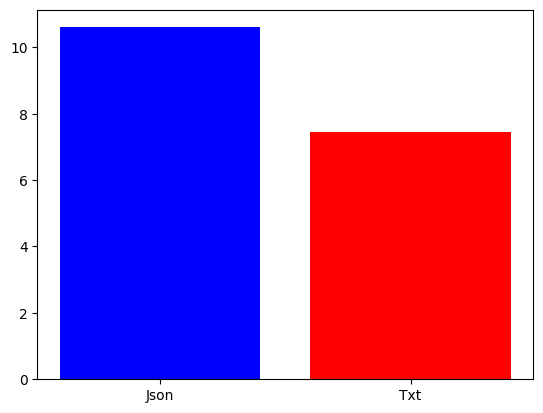

In [21]:
import requests
from pathlib import Path
from datetime import datetime
import time
import csv
import re
import json
from collections import defaultdict
import matplotlib.pyplot as plt


if __name__ == "__main__":


    word = "love"


    # Estrategia 1 (JSON)
    start = time.time()
    inverted_index_strategy1 = build_inverted_index1()
    save_inverted_index(inverted_index_strategy1)
    results = inverted_index_strategy1.get(word.lower(), set())
    end = time.time()
    result_strategy_1 = end - start
    print(f"Results for '{word}': {results}")
    print("[OK] Inverted index strategy 1")
    print(f"Strategy 1 time: {result_strategy_1:.2f} sec")
   
    # Estrategia 2 (TXT)
    start2= time.time()
    inverted_index_strategy2 = build_inverted_index2()
    save_inverted_index_txt(inverted_index_strategy2)
    txt_path = DATAMARTS_PATH / "inverted_index.txt"
    results2 = set()
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith(f"{word.lower()}:"):
                ids_str = line.split(":")[1].strip()
                results2 = set(map(int, ids_str.split(","))) if ids_str else set()
                break


    print(f"Results for '{word}' [txt search]: {results2}")
    end2 = time.time()
    result_strategy_2 = end2 - start2
    print("[OK] Inverted index strategy 2")
    print(f"Strategy 2 time: {result_strategy_2:.2f} sec")


    # Comparación en gráfica
    plt.bar(["Json", "Txt"] , [result_strategy_1, result_strategy_2], color=["blue", "red"])
    plt.show()

# Comparar tiempo de construcción del índice

In [22]:
import time

start = time.time()
inverted_index_json = build_inverted_index1()
end = time.time()
print(f"Strategy JSON build time: {end - start:.2f} sec")
start = time.time()
inverted_index_txt = build_inverted_index2()
end = time.time()
print(f"Strategy TXT build time: {end - start:.2f} sec")

Strategy JSON build time: 7.06 sec
Strategy TXT build time: 6.54 sec


# Comparar tiempo de búsqueda

In [23]:
queries = ["love", "pride", "her", "mind"]


# JSON strategy
start = time.time()
for q in queries:
    results = inverted_index_json.get(q.lower(), set())
end = time.time()
print(f"JSON search time: {end - start:.4f} sec")


# TXT strategy
start = time.time()
txt_path = DATAMARTS_PATH / "inverted_index.txt"
for q in queries:
    results_txt = set()
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith(f"{q.lower()}:"):
                ids_str = line.split(":")[1].strip()
                results_txt = set(map(int, ids_str.split(","))) if ids_str else set()
                break
end = time.time()
print(f"TXT search time: {end - start:.4f} sec")

JSON search time: 0.0005 sec
TXT search time: 0.2481 sec


# Comparar uso de memoria

In [24]:
import sys


size_json = sys.getsizeof(inverted_index_json)
print(f"JSON index memory size: {size_json / 1024:.2f} KB")


size_txt = sys.getsizeof(inverted_index_txt)
print(f"TXT index memory size: {size_txt / 1024:.2f} KB")

JSON index memory size: 20480.09 KB
TXT index memory size: 20480.09 KB


# Comparar tamnaño del disco

In [25]:
json_file = DATAMARTS_PATH / "inverted_index.json"
txt_file  = DATAMARTS_PATH / "inverted_index.txt"


print(f"JSON file size: {json_file.stat().st_size / 1024:.2f} KB")
print(f"TXT file size: {txt_file.stat().st_size / 1024:.2f} KB")

JSON file size: 24528.44 KB
TXT file size: 10913.80 KB
